In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns

# sns.set_context('talk|')?
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools


In [5]:
type = "scaled_cdf"
line_frac = 0.0

2.0
42.0


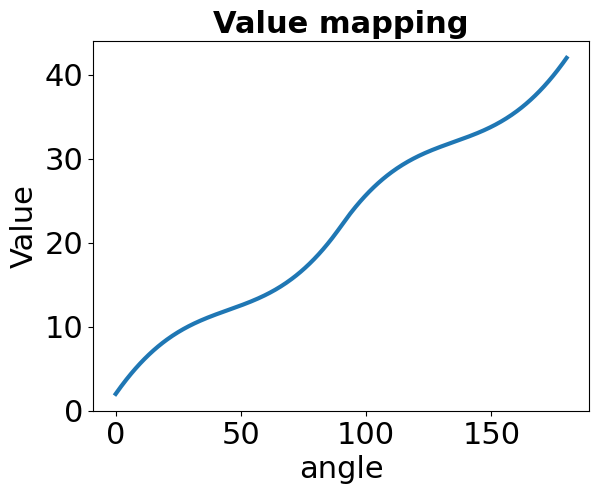

In [6]:
plt.plot(tools.stim_ori_grid*90/np.pi, tools.value_function_ori(tools.stim_ori_grid, type, line_frac))
# plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, "cdf_prior", line_frac))
# plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)


# plt.plot((tools.stim_ori_grid*90/np.pi),(tools.value_function_ori((tools.stim_ori_grid), type = "cdf_prior")))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping", size = 22,fontweight="bold")

print(min(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

print(max(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


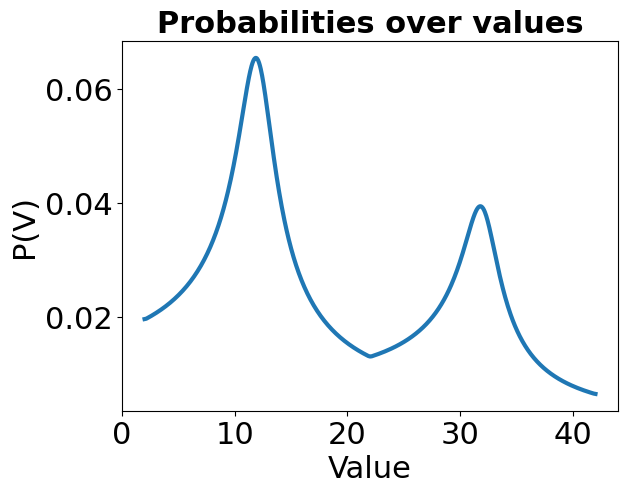

In [7]:

stim_val_grid, ps = tools.prior_val(type, line_frac)

plt.plot(stim_val_grid, ps)

trapezoid(ps, stim_val_grid)

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("Probabilities over values", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


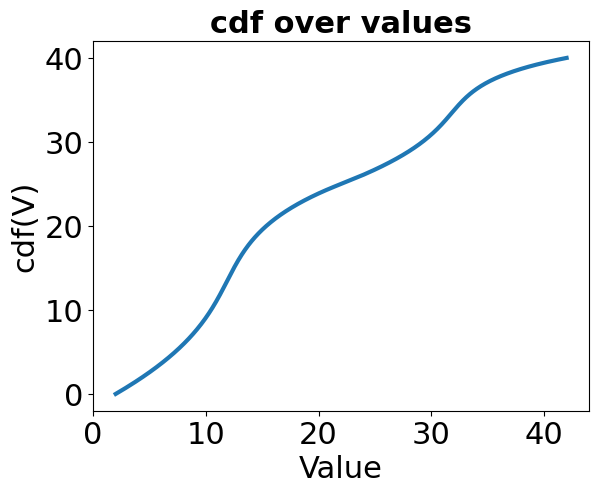

In [8]:
# stim_val_grid, ps = model.prior_val(type)
rep_val_grid, cdf_val = tools.cdf_val(type)

plt.plot(rep_val_grid, cdf_val)

plt.ylabel("cdf(V)")
plt.xlabel("Value")
plt.title("cdf over values", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


In [ ]:
stim_val_grid, ps = tools.stimulus_val_noise(0.25*np.pi, 100, model.stim_ori_grid, type)

plt.plot(stim_val_grid, ps[0,:])

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("stimulus value noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


In [ ]:
ps = tools.sensory_val_noise(10, 0.3, model.rep_val_grid)

plt.plot(tools.rep_val_grid, ps)

plt.ylabel("P(V)")
plt.xlabel("Value rep")
plt.title("sensory noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

In [ ]:

p_m_given_theta0, p_m_given_val = model.value_efficient_encoding(35./90.*np.pi, 100, 0.07, type)

# p_m_given_theta[np.argsort(tools.value_function_ori(tools.stim_ori_grid, type))]

plt.plot(model.rep_val_grid, p_m_given_theta0[0])

# plt.plot(model.rep_val_grid, p_m_given_val[400])

plt.ylabel("P(representation/V0)")
plt.xlabel("Value")
plt.title("encoded distribution", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")



In [ ]:

theta0 = 50/90.*np.pi
kappa_s = 1000
sigma_rep = np.sqrt(tools.factor_val/16) # The division is with teh analog of kappa

risk_prob = 0.75
type = "linearIncrease"
theta1 = float(tools.inverse_monotonic(tools.value_function_ori(theta0, type)/risk_prob, type))


safe_value, safe_prob = model.value_bayesian_decoding(theta0, kappa_s, sigma_rep, type)
rr, risky_prob = model.risky_value_dist(theta1, kappa_s, sigma_rep, risk_prob, type)

plt.plot(safe_value, safe_prob[0])
plt.plot(rr, risky_prob[0])

p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
print(p_chose_risky)

plt.xlabel("Value")
plt.ylabel("P(V)")
plt.title("Value mapping context 1", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")


In [ ]:
abs(trapezoid(safe_prob[0], safe_value, axis = -1))

# risk simulations

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns




# sns.set_context('talk|')?
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools

0.7567351907584199

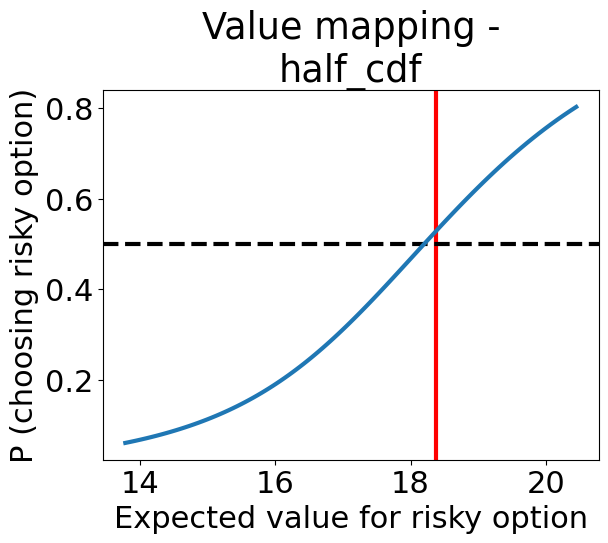

In [9]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "half_cdf" 

stim_noise = 10000
rep_noise = np.sqrt(tools.factor_val/8)
start = 60/90*np.pi

# Getting all the values from actual transformation
interval = 70/90.*np.pi
if (type=="prior" or type=="linearDecrease" or type=="curvedPrior"):
    rangeOri = np.linspace(start, (start-interval), 100)
else:
    rangeOri = np.linspace(start, (start+interval), 100)

val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

# getting inferred safe values
safe_value, safe_prob = model.safe_value_dist(rangeOri[0], stim_noise, rep_noise, type)
risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)


# # Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

# plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)



# comparing models : same noise regimes fopr safe and risky option

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk|')
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np
import pandas as pd

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools


In [2]:
def rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="curvedPrior" or type =="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        # print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
0.22389252576345575
safe angle -  4.125882352941177
0.4761691671207896
safe angle -  7.251764705882353
0.6795994525908664
safe angle -  10.377647058823527
0.7667562436806326
safe angle -  13.503529411764706
0.7802846755796727
safe angle -  16.629411764705882
0.7671735582333966
safe angle -  19.755294117647058
0.7577818473450415
safe angle -  22.881176470588237
0.7546659439785068
safe angle -  26.00705882352941
0.7537876759086878
safe angle -  29.132941176470585
0.7531940595987726
safe angle -  32.258823529411764
0.752432689862093
safe angle -  35.38470588235294
0.7514862927991396
safe angle -  38.510588235294115
0.7505028246460592
safe angle -  41.63647058823529
0.7494850158162245
safe angle -  44.76235294117647
0.7485472448174282
safe angle -  47.88823529411764
0.7476815956292812
safe angle -  51.014117647058825
0.7470033476680008
safe angle -  54.13999999999999
0.7463786201206769
safe angle -  57.265882352941176
0.7459069878617758
safe angle -  60.391764705882345
0.

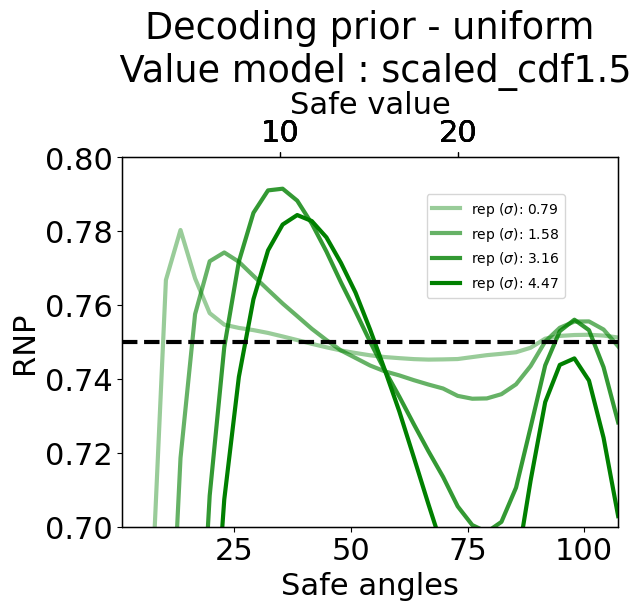

In [7]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4), np.sqrt(tools.factor_val/2)]
    # stim_list = [64, 16, 8, 4]
    # rep_list = [np.sqrt(tools.factor_val/128)]


    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    alphaList = np.linspace(0.4, 1.0, len(rep_list))
    i = 0

    for stim_noise in stim_list:
        for rep_noise in rep_list:

            safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
            ax1.set_ylim(0.7, 0.8)
            ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

            text = "rep ($\sigma$): "+str(round(rep_noise,2))
            ax1.plot(safe_angles[:]*90./np.pi, rnp[:], color = "green", alpha = alphaList[i], label = text)
            i = i+1

            ax2 = ax1.twiny()
            if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
                ax2.set_xlim(max(safeVals), min(safe_angles))

            ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")
    if type == "scaled_cdf":
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Value model : " + type) 

    plt.savefig("/Users/sbedi/Downloads/"+"sameNoise-valuation-"+tools.contextual_prior+".png",dpi=300, bbox_inches = "tight")
   

# different sensory noises fpr two options

In [8]:
def rnp_diffNoises(stim_noise, safe_rep_noise, risky_rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="curvedPrior" or type =="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri*90/np.pi)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # print("safeval - ", safeVal, "range val - ", val_range)

        # getting inferred safe values for the two different noise types forthe two options
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, safe_rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, risky_rep_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
[0.29854341 0.30039128 0.3027099  0.30514167 0.30768749 0.31035382
 0.31314743 0.31607545 0.31914549 0.32236561]
0.22389252576345575
safe angle -  4.125882352941177
[0.2992778  0.30575184 0.31285885 0.32066505 0.32924305 0.33866729
 0.34901723 0.36037134 0.37280691 0.38639648]
0.4761691671207896
safe angle -  7.251764705882353
[0.29750193 0.31218431 0.32905011 0.34833041 0.37021336 0.39480408
 0.42208212 0.4518664  0.48378826 0.51729357]
0.6795994525908664
safe angle -  10.377647058823527
[0.28537458 0.3145743  0.34882141 0.387767   0.43043953 0.47534253
 0.52076044 0.56514501 0.6073969  0.64693405]
0.7667562436806326
safe angle -  13.503529411764706
[0.24744226 0.29360211 0.34576207 0.40086458 0.45624643 0.51033912
 0.56245749 0.61228084 0.65951826 0.70383571]
0.7802846755796727
safe angle -  16.629411764705882
[0.17765478 0.23236577 0.29384732 0.35987849 0.42898733 0.49947965
 0.56931877 0.63643929 0.6990814  0.7559797 ]
0.7671735582333966
safe angle -  19.755294117

TypeError: 'Line2D' object is not iterable

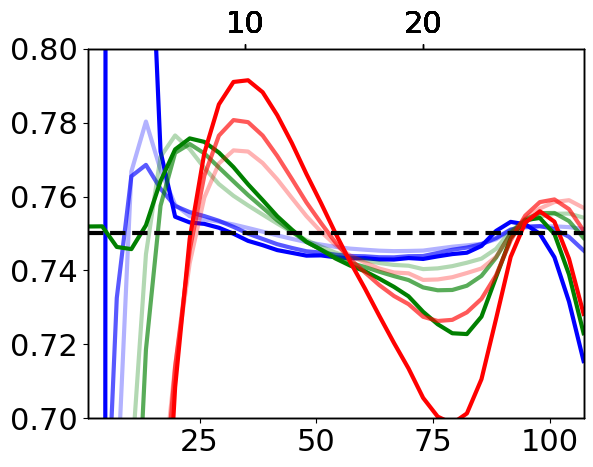

In [17]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    safe_rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    risky_rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # High stim noise
    # stim_list = [64, 16, 8, 4]
    # rep_list = [128]

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    alphaList = np.linspace(0.3, 1.0, len(risky_rep_list))
    colorList = ["b", "g", "r", "c", "m", "y", "k"]
    plot_lines = []
    j = -1
    for stim_noise in stim_list:
        for safe_rep_noise in safe_rep_list:
            j = j+1
            i = -1
            for risky_rep_noise in risky_rep_list:
                i = i+1
                safe_angles, safeVals, rnp = rnp_diffNoises(stim_noise, safe_rep_noise, risky_rep_noise, type, risk_prob, experimentEffects)
                ax1.set_ylim(0.7, 0.8)
                ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

                text = "safe_rep ($\sigma$): "+str(round(safe_rep_noise, 2)) + "; risky_rep ($\sigma$): "+str(round(risky_rep_noise, 2))
                l, = ax1.plot(safe_angles[:]*90./np.pi, rnp[:], color=colorList[j], label = text, alpha =  alphaList[i])
                plot_lines.append(l)
                ax2 = ax1.twiny()
                if (type=="prior" or type=="curvedPrior" or type == "linearDecrease"):
                    ax2.set_xlim(max(safeVals), min(safe_angles))

                ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    legend1 = ax1.legend(plot_lines[0], ["low_noise", "med_noise", "high_noise"], loc=1)
    ax1.legend([l[0] for l in plot_lines], safe_rep_noise, loc=4)

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")
    if type == "scaled_cdf":
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Valuation model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Decoding prior - " + tools.contextual_prior + "\n Valuation model : " + type) 

    plt.savefig("/Users/sbedi/Downloads/diffNoises-valuation"+tools.contextual_prior+".png",dpi=300, bbox_inches = "tight")
    

In [16]:
plot_lines
print(l[0] for l in plot_lines)

<generator object <genexpr> at 0x7fa26982ecf0>


# diff

In [ ]:

def rnp_safeVals_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)


        safeVal = tools.value_function_ori(safe_angles[i], type)
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.value_bayesian_decoding(safe_angles[i], safeNoise[0], safeNoise[1], type)
        risky_value, risky_prob = model.risky_value_dist((rangeOri), riskyNoise[0], riskyNoise[1], risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
    return safe_angles, safeVals, rnp

    

In [ ]:

# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

# changeable parameters
high_stim_list = [32]
low_stim_list = [10000]
high_rep_list = [np.sqrt(tools.factor_val/8)]
low_rep_list = [np.sqrt(tools.factor_val/64)]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for high_stim_noise in high_stim_list:
    for high_rep_noise in high_rep_list:
        for low_stim_noise in low_stim_list:
            for low_rep_noise in low_rep_list:

                safeNoise = [low_stim_noise, high_rep_noise]
                riskyNoise = [high_stim_noise, low_rep_noise]

                safe_angles, safeVals, rnp = rnp_safeVals_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects)

                ax1.set_ylim(0.6, 0.85)

                text = "Safe stim (k): "+ str(safeNoise[0])+" Safe rep ($\sigma$): "+str(safeNoise[1])
                # text = "Risky stim (k): "+ str(riskyNoise[0])+"; Risky rep ($\sigma$): "+str(riskyNoise[1])


                ax1.plot(safeVals[:], rnp[:], label = text)

                ax2 = ax1.twiny()
                if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
                    ax2.set_xlim(max(safe_angles*90./np.pi), min(safe_angles*90./np.pi))
                ax2.plot(safe_angles*90./np.pi, np.ones(len(safe_angles))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(1.05, 0.9), prop={'size': 10})

ax2.set_xlabel("\n Safe angle")
ax1.set_xlabel("Safe Value")
ax1.set_ylabel("RNP")
# if len(safeNoise[0])==1 and len(safeNoise[1])==1:
# ax1.set_title("Value : " + type + "\n safe stim (k): "+str(safeNoise[0])+"; safe rep ($\sigma$): "+str(safeNoise[1]))
# else:
ax1.set_title("Value : " + type + "\n risky stim (k): "+str(riskyNoise[0])+" risky rep ($\sigma$): "+str(riskyNoise[1]))
plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

# just for a safe angle

In [ ]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

stim_noise = 10000
rep_noise = 0.07
start = 80

# Getting all the values from actual transformation
interval = 50
rangeOri = np.linspace(start/90., (start+interval)/90., 100)*np.pi
val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)


# getting inferred safe values
safe_value, safe_prob = model.value_bayesian_decoding(rangeOri[0], stim_noise, rep_noise, type)
risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)


# # Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

# plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)



In [ ]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
types = ["cdf_prior", "scaled_cdf"]
# type = "curved_cdf_prior"

for type in types:

    # changeable parameters
    stim_list = [10000]
    rep_list = [np.sqrt(tools.factor_val/64), np.sqrt(tools.factor_val/16), np.sqrt(tools.factor_val/4)]
    # stim_list = [64, 16, 8, 4]
    # rep_list = [np.sqrt(tools.factor_val/128)]


    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    for stim_noise in stim_list:
        for rep_noise in rep_list:

            safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
            ax1.set_ylim(0.7, 0.8)
            ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

            text = "stim (k): "+ str(stim_noise)+"; rep ($\sigma$): "+str(round(rep_noise,2))
            ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


            ax2 = ax1.twiny()
            if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
                ax2.set_xlim(max(safeVals), min(safe_angles))

            ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

    ax1.axhline(risk_prob, c='k', ls='--')
    ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

    ax2.set_xlabel("Safe value")
    ax1.set_xlabel("Safe angles")
    ax1.set_ylabel("RNP")
    if type == "scaled_cdf":
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Value model : " + type+str(tools.scaling)) 
    else:
        ax1.set_title("Exp range - " + tools.experimentRange + "\n Value model : " + type) 

    plt.savefig("/Users/sbedi/Downloads/"+tools.contextual_prior+"-valuation-.png",dpi=300, bbox_inches = "tight")
   